In [1]:
# Training ResNet for MHI dataset
# Code based on cuda GPU
# Trained dataset on 2022/07/22

In [2]:
import os
from collections import Counter
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from torch import cuda, optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

%matplotlib inline
plt.rcParams['font.size'] = 14

In [3]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [4]:
# Set data directories
traindir = f"data/train"
validdir = f"data/val"
testdir = f"data/test"

In [5]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet" ###

save_file_name = f'{model_name}-transfer.pt'
checkpoint_path = f'{model_name}-transfer.pth'
print(f'model name: {model_name}')

# Change to fit hardware
batch_size = 32

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
print(train_on_gpu,multi_gpu)

Train on gpu: True
1 gpus detected.
True False


In [6]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
        # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

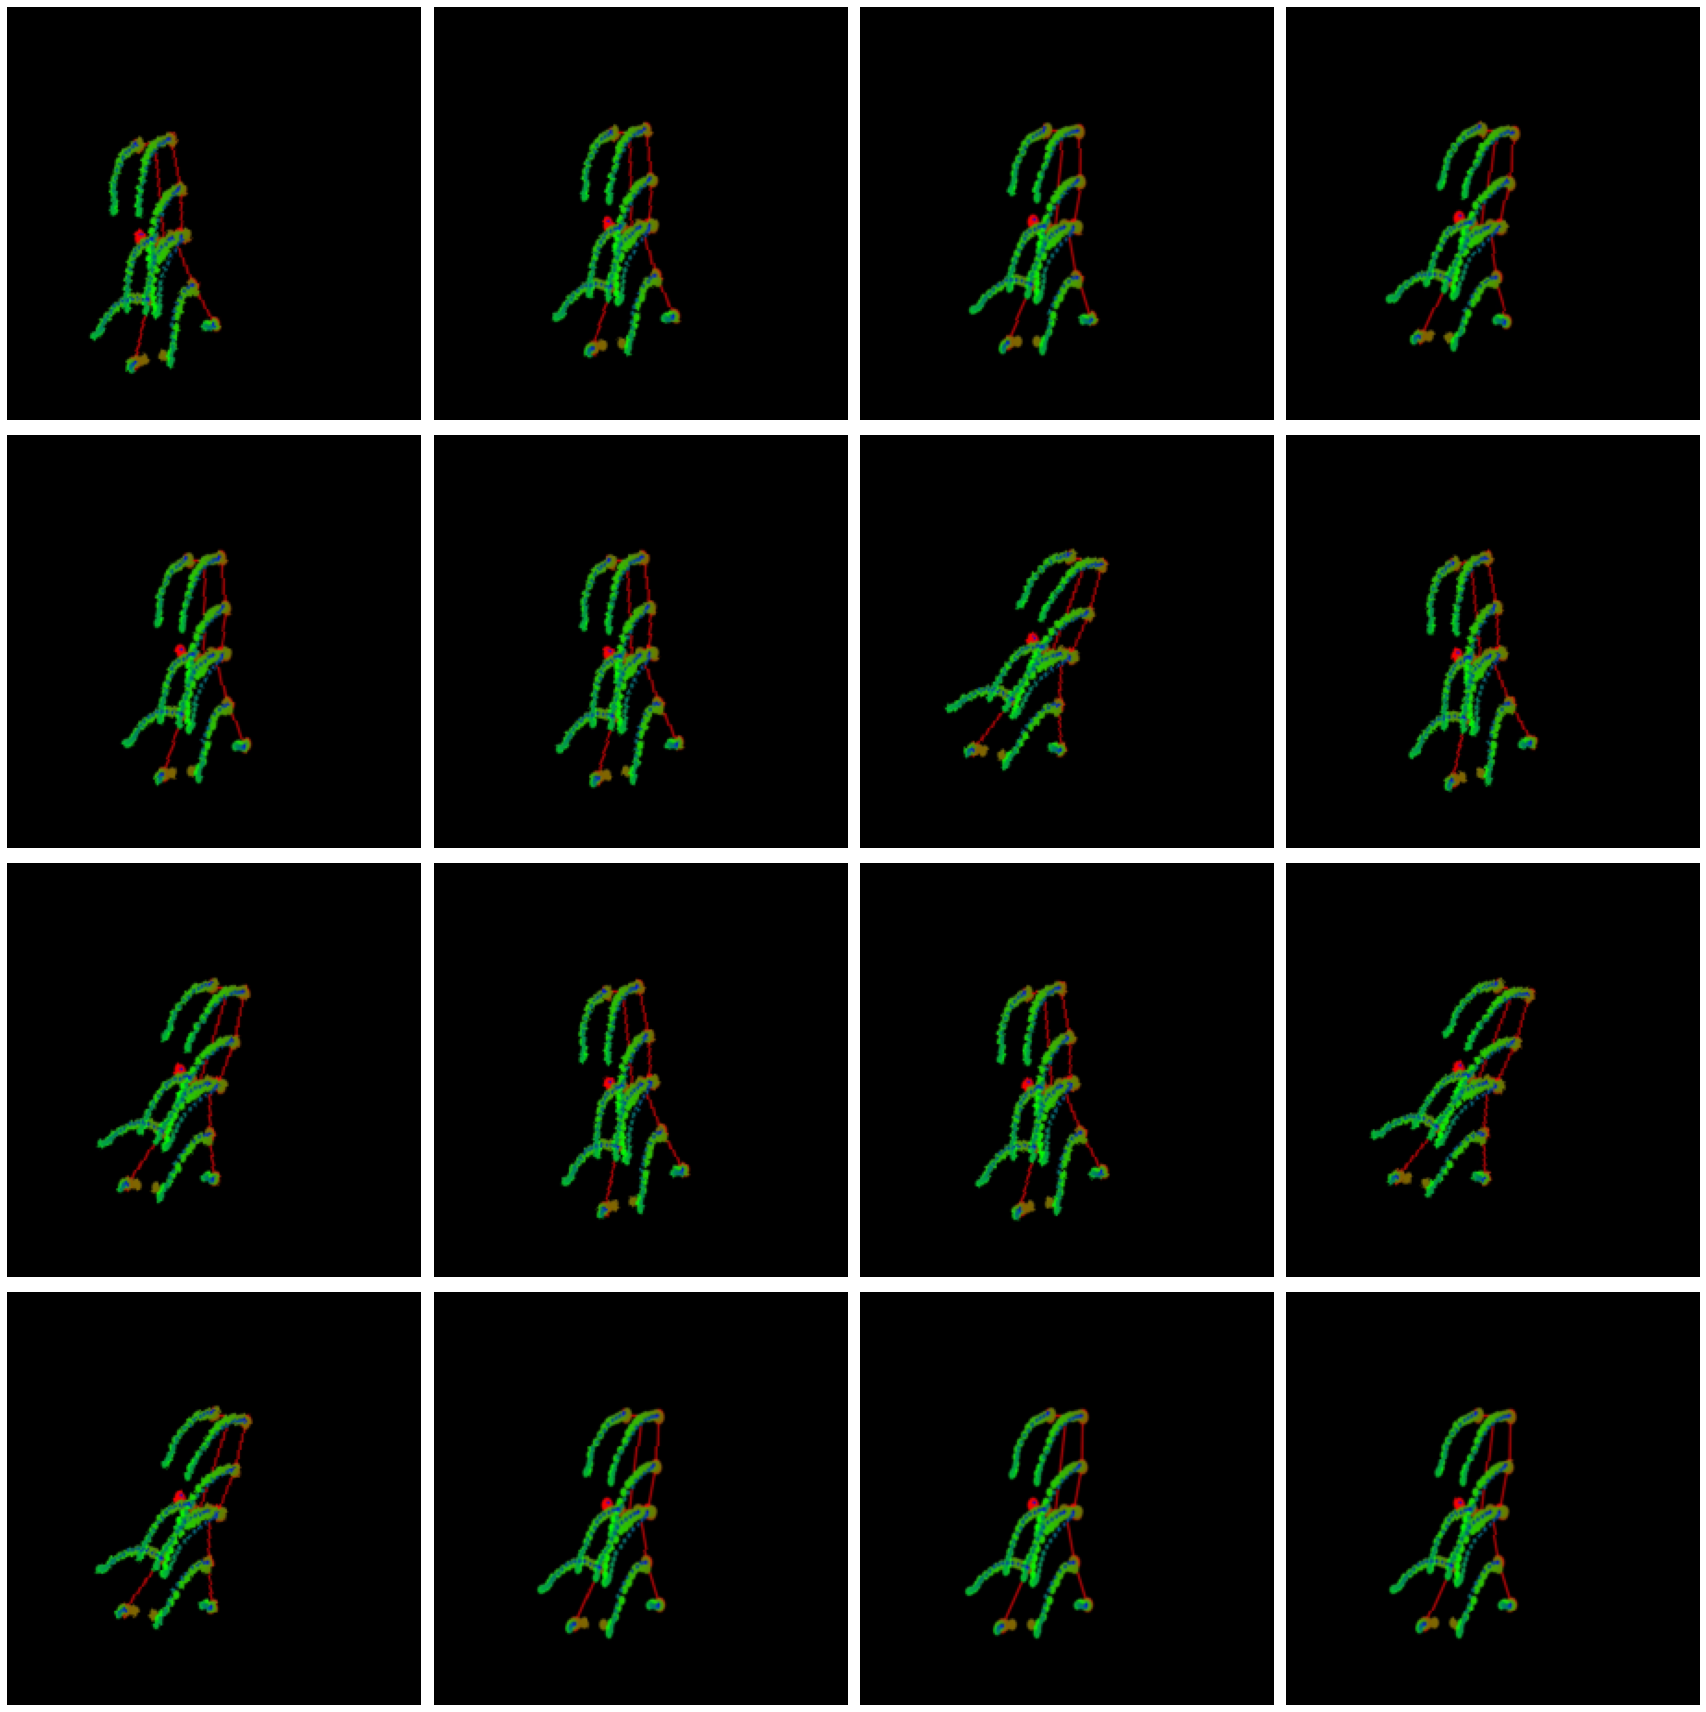

In [7]:
# Sample transformations on training data
ex_img = Image.open('data/test/Lunge/lunge_11_1.png')

t = image_transforms['train']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

In [8]:
# Datasets from folders
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'valid':
    datasets.ImageFolder(root=validdir, transform=image_transforms['valid']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(data['valid'], batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True, num_workers=0)
}

In [9]:
# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [10]:
categories = []
for d in os.listdir(traindir):
    categories.append(d)
    
n_classes = len(categories)
print(f'There are {n_classes} different classes: {categories}')


There are 5 different classes: ['Pushup', 'Squat', 'Lunge', 'Stand', 'Lying']


In [11]:
class_to_idx = data['train'].class_to_idx
idx_to_class = {
    idx: class_
    for class_, idx in data['train'].class_to_idx.items()
}

In [12]:
train_cnts = Counter([idx_to_class[x] for x in data['train'].targets])
val_cnts = Counter([idx_to_class[x] for x in data['valid'].targets])
test_cnts = Counter([idx_to_class[x] for x in data['test'].targets])

In [13]:
train_cnts = pd.DataFrame({'cat' :list(train_cnts.keys()), 'train_cnt': list(train_cnts.values())})
val_cnts = pd.DataFrame({'cat' :list(val_cnts.keys()), 'val_cnt': list(val_cnts.values())})
test_cnts = pd.DataFrame({'cat' :list(test_cnts.keys()), 'test_cnt': list(test_cnts.values())})

In [14]:
cnt_df = pd.merge(train_cnts,val_cnts,on='cat',how='left').merge(test_cnts,on='cat',how='left')

In [15]:
# Show data directories
cnt_df.head()

,cat,train_cnt,val_cnt,test_cnt
0,Lunge,328,41,41
1,Lying,107,14,13
2,Pushup,238,30,30
3,Squat,262,33,33
4,Stand,106,13,13


In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        print('basic')
        print(model_ft)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [16]:
#model = models.resnet50(pretrained=True)
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [ ]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [17]:
'''# Freeze model weights
for param in model.parameters():
    param.requires_grad = False'''

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

In [18]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
n_inputs = model.fc.in_features

In [20]:
# Modify fully-connected layer to match output classes
model.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

In [21]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=5, bias=True)
  (4): LogSoftmax(dim=1)
)

In [22]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

24,033,861 total parameters.
525,829 training parameters.


In [23]:
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

In [24]:
if multi_gpu:
    print(model.module.fc)
else:
    print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=5, bias=True)
  (4): LogSoftmax(dim=1)
)


In [25]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'Lunge'), (1, 'Lying'), (2, 'Pushup'), (3, 'Squat'), (4, 'Stand')]

In [26]:
#criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [27]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 2048])
torch.Size([256])
torch.Size([5, 256])
torch.Size([5])


In [28]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history


In [29]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=100,
    n_epochs=100,
    print_every=1)

Starting Training from Scratch.

Epoch: 0	100.00% complete. 93.75 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 0.9490 	Validation Loss: 0.6050
		Training Accuracy: 65.90%	 Validation Accuracy: 76.34%
Epoch: 1	100.00% complete. 96.42 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.3537 	Validation Loss: 0.4556
		Training Accuracy: 90.11%	 Validation Accuracy: 86.26%
Epoch: 2	100.00% complete. 92.29 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.2440 	Validation Loss: 0.3607
		Training Accuracy: 91.83%	 Validation Accuracy: 86.26%
Epoch: 3	100.00% complete. 92.77 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.1775 	Validation Loss: 0.2738
		Training Accuracy: 94.62%	 Validation Accuracy: 87.79%
Epoch: 4	100.00% complete. 92.30 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.1496 	Validation Loss: 0.2760
		Training Accuracy: 95.58%	 Validation Accuracy: 90.08%
Epoch: 5	100.00% complete. 92.35 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.1080 	Validation

Epoch: 48	100.00% complete. 85.96 seconds elapsed in epoch.
Epoch: 48 	Training Loss: 0.0546 	Validation Loss: 0.1445
		Training Accuracy: 98.17%	 Validation Accuracy: 93.89%
Epoch: 49	100.00% complete. 88.68 seconds elapsed in epoch.
Epoch: 49 	Training Loss: 0.0757 	Validation Loss: 0.1564
		Training Accuracy: 97.12%	 Validation Accuracy: 93.13%
Epoch: 50	100.00% complete. 90.06 seconds elapsed in epoch.
Epoch: 50 	Training Loss: 0.0878 	Validation Loss: 0.1920
		Training Accuracy: 96.64%	 Validation Accuracy: 93.89%
Epoch: 51	100.00% complete. 92.71 seconds elapsed in epoch.
Epoch: 51 	Training Loss: 0.0656 	Validation Loss: 0.1694
		Training Accuracy: 97.60%	 Validation Accuracy: 93.13%
Epoch: 52	100.00% complete. 85.93 seconds elapsed in epoch.
Epoch: 52 	Training Loss: 0.0619 	Validation Loss: 0.1862
		Training Accuracy: 97.60%	 Validation Accuracy: 92.37%
Epoch: 53	100.00% complete. 86.36 seconds elapsed in epoch.
Epoch: 53 	Training Loss: 0.0866 	Validation Loss: 0.2223
		Train

Epoch: 95	100.00% complete. 86.00 seconds elapsed in epoch.
Epoch: 95 	Training Loss: 0.0113 	Validation Loss: 0.1339
		Training Accuracy: 99.62%	 Validation Accuracy: 95.42%
Epoch: 96	100.00% complete. 86.18 seconds elapsed in epoch.
Epoch: 96 	Training Loss: 0.0586 	Validation Loss: 0.0883
		Training Accuracy: 98.17%	 Validation Accuracy: 96.18%
Epoch: 97	100.00% complete. 86.38 seconds elapsed in epoch.
Epoch: 97 	Training Loss: 0.0371 	Validation Loss: 0.2371
		Training Accuracy: 98.66%	 Validation Accuracy: 91.60%
Epoch: 98	100.00% complete. 86.06 seconds elapsed in epoch.
Epoch: 98 	Training Loss: 0.0432 	Validation Loss: 0.1043
		Training Accuracy: 98.37%	 Validation Accuracy: 96.18%
Epoch: 99	100.00% complete. 86.51 seconds elapsed in epoch.
Epoch: 99 	Training Loss: 0.0386 	Validation Loss: 0.1862
		Training Accuracy: 98.66%	 Validation Accuracy: 94.66%

Best epoch: 79 with loss: 0.08 and acc: 94.66%
10013.49 total seconds elapsed. 101.15 seconds per epoch.


Text(0.5, 1.0, 'Training and Validation Losses')

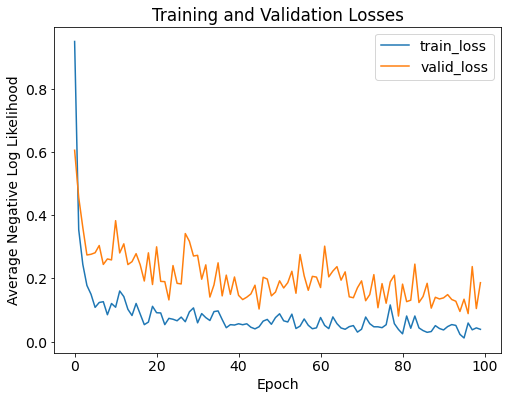

In [30]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

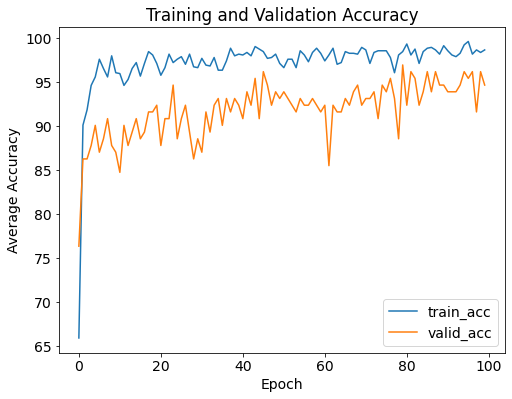

In [31]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [32]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [33]:
save_checkpoint(model, path=checkpoint_path)